## Library importing

In [31]:
from utils import LossRecorder, create_dataloader, predict_modified, normalize
from hierarchical_label_tree import build_hlt, squeeze_tree
from data import translate_labels_to_clusters
from torch.nn.utils import clip_grad_value_
from model import AttentionXMLModified
from sklearn.cluster import KMeans
import torch.nn.functional as fn
from collections import Counter
import torch.optim as optim
from copy import deepcopy
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import numpy as np
import pickle
import ctypes
import torch
import os
import gc

libc = ctypes.CDLL("libc.so.6")

BUILD_HLT = False
# TYPE_OF_REPRESENTATIONS = 'transformer'
TYPE_OF_REPRESENTATIONS = 'xml'

k = 3
level_growth = 4
batch_size = 400
embedding_size = 768
cluster_model = KMeans

path_to_data = '...'
path_to_hlt = '...'
path_to_embeddings = '...'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_detect_anomaly(True)

## Preprocess

In [4]:
train_df = pd.read_csv(f'{path_to_data}/train.csv')
test_df = pd.read_csv(f'{path_to_data}/test.csv')

train_df['tags'] = train_df['tags'].str.split(',').apply(lambda x: list(map(int, x)))
train_df = train_df.set_index('track')

In [5]:
tags_flattened = sum(train_df['tags'].values.tolist(), [])
all_labels = np.unique(tags_flattened)
number_of_leaves = len(all_labels)

In [6]:
if BUILD_HLT and TYPE_OF_REPRESENTATIONS == 'transformer':

    labels_distribution = Counter(tags_flattened)
    labels_probas = [1 - value / number_of_leaves * 50 for label, value in labels_distribution.most_common()]
    labels_probas = fn.sigmoid(torch.Tensor(labels_probas))
    labels_probas = torch.stack((labels_probas, 1 - labels_probas), dim=-1)
    labels_probas = dict(zip(labels_distribution.keys(), labels_probas.tolist()))
    label_embeddings = np.zeros((len(all_labels), embedding_size))

    for file in tqdm(os.listdir(path_to_embeddings)):

        try:
            idx = int(file.split('.')[0])
            tags = train_df.loc[idx]['tags']
        except:
            continue

        embeddings = np.load(f'{path_to_embeddings}/{file}')
        probas = [labels_probas[label] for label in tags]
        probas = np.round(probas, decimals=4)
        embeddings_included = [np.random.choice([0, 1], size=embeddings.shape[0], p=proba) for proba in probas]
        embeddings_included = np.array(embeddings_included)
        embeddings_indexes = np.repeat(np.arange(embeddings.shape[0]).reshape((1, embeddings.shape[0])), len(tags), axis=0)
        embeddings_indexes = embeddings_indexes * embeddings_included
        embedding_indexes = [[elem for elem in sublst if elem != 0] for sublst in embeddings_indexes]

        for label, idxs in zip(tags, embeddings_indexes):
            label_embeddings[label] += np.sum(embeddings[idxs], axis=0)

    for label in all_labels:

        label_embeddings[label] = normalize(label_embeddings[label])

    label_embeddings = torch.from_numpy(label_embeddings).to(device).float()

## Embedding labels using a transformer

In [11]:
head_number = 8
ffnn_size = 4 * embedding_size
dropout = 0.33
layer_number = 4
num_epochs = 10
learning_rate = 0.003

train_indexes = train_df.index.values
train_labels = train_df['tags'].values
recorder = LossRecorder(['transformer'])

train_dataloader = create_dataloader(
    batch_size=70,
    shuffle=True,
    indexes=train_indexes,
    labels=train_labels,
    size=number_of_leaves
)

layer = nn.TransformerEncoderLayer(embedding_size, head_number, ffnn_size, dropout=dropout, batch_first=True)
transformer_encoder = nn.TransformerEncoder(layer, layer_number)
model = nn.Sequential(transformer_encoder, nn.Linear(embedding_size, number_of_leaves)).to(device)
model[1].weight.data = label_embeddings.to(device) if BUILD_HLT else torch.empty((len(all_labels), embedding_size)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

if BUILD_HLT and TYPE_OF_REPRESENTATIONS == 'transformer':
    
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()

            cls_embedding = torch.ones((inputs.size(0), 1, inputs.size(-1))).to(device)
            inputs = torch.cat((cls_embedding, inputs), dim=1)
            logits = model.forward(inputs)
            logits = logits[:, 0, :]

            loss = criterion(logits, labels)
            recorder.add(loss.item())
            loss.backward()
            optimizer.step()

In [12]:
if BUILD_HLT and TYPE_OF_REPRESENTATIONS == 'transformer':
    
    label_embeddings = dict(enumerate(model[1].weight.data.cpu().numpy()))
    recorder.show(y_lim=(0, 0.2), size=(16, 6))

## Loading embeddings

In [13]:
if BUILD_HLT:
    
    if TYPE_OF_REPRESENTATIONS == 'transformer':

        hlt, hlt_representations = build_hlt(all_labels, label_embeddings, cluster_model)
        hlt = squeeze_tree(hlt)
        hlt_representations = squeeze_tree(hlt_representations)
        hlt_repr_for_save = [embedding.tolist() for embedding in hlt_representations]
        
        with open(f'{path_to_hlt}/hlt.pickle', 'wb') as f:
            pickle.dump(hlt, f)
        with open(f'{path_to_hlt}/hlt_representations.pickle', 'wb') as f:
            pickle.dump(hlt_repr_for_save, f, protocol=pickle.HIGHEST_PROTOCOL)

        del label_embeddings, model
        
else:
    
    with open(f"{path_to_data}/hlt{'' if TYPE_OF_REPRESENTATIONS == 'transformer' else '_from_xml'}.pickle", 'rb') as f:
        hlt = pickle.load(f)
    with open(f"{path_to_data}/hlt_representations{'' if TYPE_OF_REPRESENTATIONS == 'transformer' else '_from_xml'}.pickle", 'rb') as f:
        hlt_representations = pickle.load(f)
    hlt_representations = [torch.tensor(embedding).float() for embedding in hlt_representations]
    
for level in hlt:
    print(len(level))

del train_dataloader, layer, transformer_encoder
_ = gc.collect()
libc.malloc_trim(0)

1
4
16
64
256


1

## Training part 

In [41]:
torch.cuda.empty_cache()
_ = gc.collect()
libc.malloc_trim(0)

1

In [42]:
PREDICT = True

learning_rate = 0.0001
ffnn_size = 4 * embedding_size
criterion = nn.BCEWithLogitsLoss(reduction='mean')
xml_recorder = LossRecorder(names=['0 level', '1 level', '2 level', '3 level'])
number_of_layers = [1, 1, 1, 1]
number_of_epochs = [9, 9, 9, 9]

number_of_leaves = len(hlt[-1])
number_of_ks = [len(hlt[1]), 2 * k, k ** 2, number_of_leaves]
test_indexes = test_df['track'].values
label_probas = torch.full((test_df.shape[0], number_of_leaves), 1.0)
last_model = None

for i, (level, representations) in enumerate(zip(hlt[1:], hlt_representations[1:])):
   
    train_clusters = translate_labels_to_clusters(train_labels, level)
    train_dataloader = create_dataloader(
        batch_size=batch_size,
        shuffle=True,
        indexes=train_indexes,
        labels=train_clusters,
        size=len(level)
    )
    model = AttentionXMLModified(
        representations,
        embedding_size,
        number_of_layers[i],
        ffnn_size,
        copy_model=last_model
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(number_of_epochs[i])):
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            
            logits = model.forward(inputs, None)
            logits = logits.squeeze(-1)
            loss = criterion(logits, labels)
            
            loss.backward()
            xml_recorder.add(loss.item(), to=i)
            clip_grad_value_(model.parameters(), 5.0)
            optimizer.step()
  
    if PREDICT:
        
        test_dataloader = create_dataloader(
            batch_size=batch_size,
            shuffle=False,
            indexes=test_indexes,
            size=len(level)
        )
        
        probas = predict_modified(model, test_dataloader)
        label_probas = label_probas * probas
    
    last_model = deepcopy(model)
    gc.collect()

100%|██████████| 9/9 [31:29<00:00, 209.92s/it]


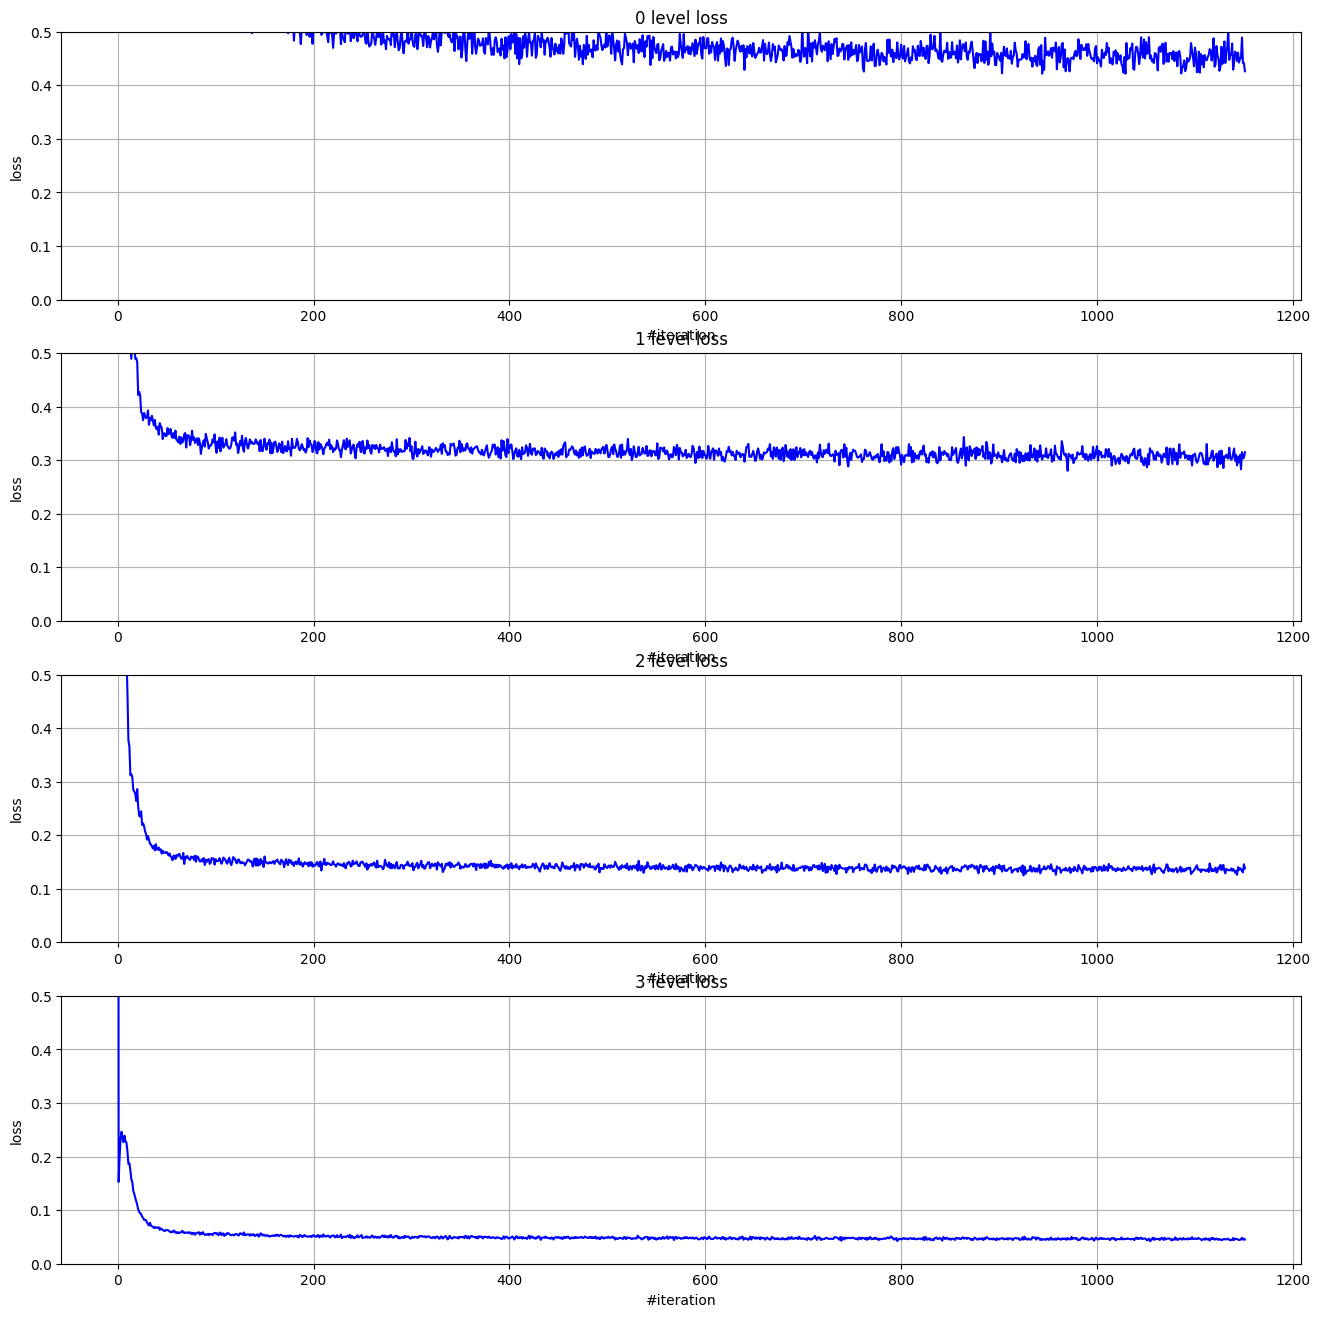

In [48]:
xml_recorder.show(y_lim=(0, 0.5))

In [35]:
torch.cuda.empty_cache()
_ = gc.collect()
libc.malloc_trim(0)

1

## Changes with different number of layers

In [36]:
optimizing_index = 0
range_of_layers = range(1, 3)

num_epochs = 9
learning_rate = 0.0001
ffnn_size = 4 * embedding_size
criterion = nn.BCEWithLogitsLoss(reduction='mean')
tune_recorder = LossRecorder(names=[f'{l} layers' for l in range_of_layers])

train_ancestors = [list(range(len(hlt[optimizing_index])))] * len(train_indexes)
representations = hlt_representations[optimizing_index+1]
level = hlt[optimizing_index+1]

for i, num_layers in enumerate(range_of_layers):
   
    train_clusters = translate_labels_to_clusters(train_labels, level)
    train_dataloader = create_dataloader(
        batch_size=batch_size,
        shuffle=True,
        indexes=train_indexes,
        labels=train_clusters,
        size=len(level)
    )
    model = AttentionXMLModified(
        representations,
        embedding_size,
        num_layers,
        ffnn_size
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            
            logits = model.forward(inputs, None)
            logits = logits.squeeze(-1)
            loss = criterion(logits, labels)
            
            loss.backward()
            tune_recorder.add(loss.item(), to=i)
            clip_grad_value_(model.parameters(), 5.0)
            optimizer.step()

100%|██████████| 9/9 [22:58<00:00, 153.13s/it]


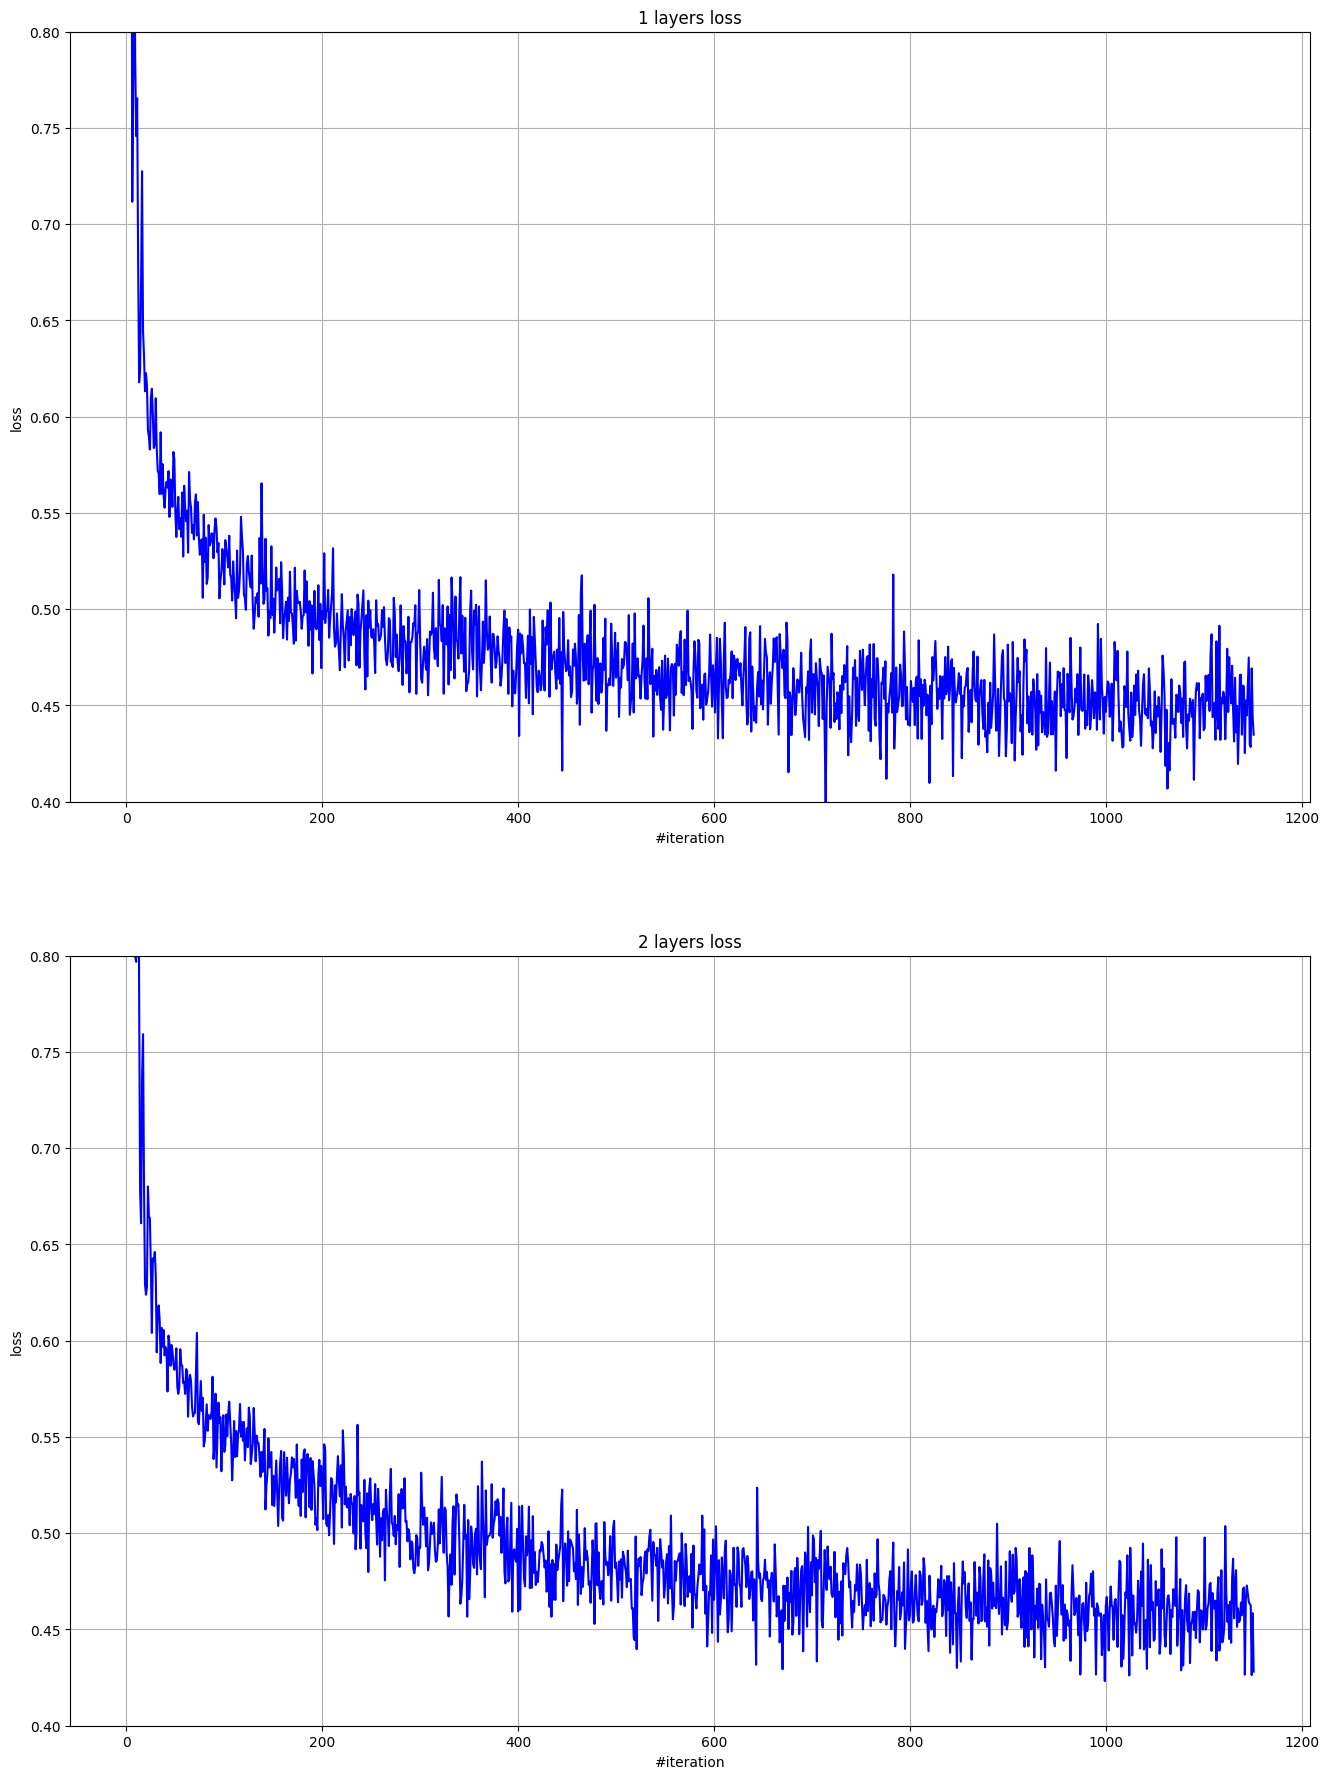

In [39]:
tune_recorder.show(y_lim=(0.4, 0.8), size=(16, 22))

In [53]:
if BUILD_HLT and TYPE_OF_REPRESENTATIONS == 'xml':
        
    label_embeddings = dict(sorted(zip(sum(hlt[-1], []), last_model.output.data.cpu().numpy().T), key=lambda x: x[0]))

    hlt, hlt_representations = build_hlt(all_labels, label_embeddings, cluster_model)
    hlt = squeeze_tree(hlt)
    hlt_representations = squeeze_tree(hlt_representations)
    hlt_repr_for_save = [embedding.tolist() for embedding in hlt_representations]

    with open(f'{path_to_hlt}/hlt_from_xml.pickle', 'wb') as f:
        pickle.dump(hlt, f)
    with open(f'{path_to_hlt}/hlt_representations_from_xml.pickle', 'wb') as f:
        pickle.dump(hlt_repr_for_save, f, protocol=pickle.HIGHEST_PROTOCOL)

2
4
8
16
32
64
128
256


## Saving

In [50]:
if PREDICT:

    predictions = label_probas.clone()
    labels = deepcopy(hlt[-1])
    predictions = [list(map(lambda x: x[1].tolist(), sorted(zip(labels, probas), key=lambda x: x[0][0]))) for probas in predictions]
    
predictions[0]

[0.0013519938802346587,
 0.02866150625050068,
 0.00765201635658741,
 0.02597341500222683,
 1.793890078261029e-05,
 1.6130715039253118e-06,
 0.013193069957196712,
 3.85597741114907e-06,
 8.50489414006006e-06,
 0.00022866862127557397,
 5.14917928740033e-07,
 0.0002457963419146836,
 0.00011287713277852163,
 2.7348680305294693e-05,
 9.829540067585185e-05,
 0.0004297349078115076,
 1.1409953515340021e-07,
 1.0592099897621665e-05,
 9.629538766375845e-08,
 0.000393589842133224,
 8.636886406065969e-08,
 3.1467391181649873e-07,
 5.179896834306419e-05,
 0.005366046447306871,
 4.196077134110965e-05,
 0.00039966273470781744,
 1.1836034900625236e-05,
 3.13564964926627e-06,
 1.4826235883447225e-07,
 4.855118618252163e-08,
 0.0012651480501517653,
 0.00010968243441311643,
 5.5823395086918026e-05,
 1.2113253433199134e-05,
 3.504918311136862e-08,
 5.204281023907242e-07,
 7.362296400970081e-06,
 5.62614388854854e-07,
 5.0067941629095e-05,
 0.0006667827838100493,
 1.1259473353675276e-07,
 1.13276178126398e

In [51]:
submission = test_df.copy()
submission['prediction'] = list(map(lambda probas: ','.join([str(x) for x in probas]), predictions))

submission.to_csv('submission.csv', index=False)
submission.head()

,track,prediction
0,17730,"0.0013519938802346587,0.02866150625050068,0.00..."
1,32460,"0.004621586762368679,0.1615336388349533,0.0972..."
2,11288,"2.1887410184717737e-05,0.05113428458571434,0.0..."
3,18523,"0.2183668613433838,0.005625207908451557,0.0327..."
4,71342,"6.435881368815899e-05,7.912521687103435e-05,0...."
